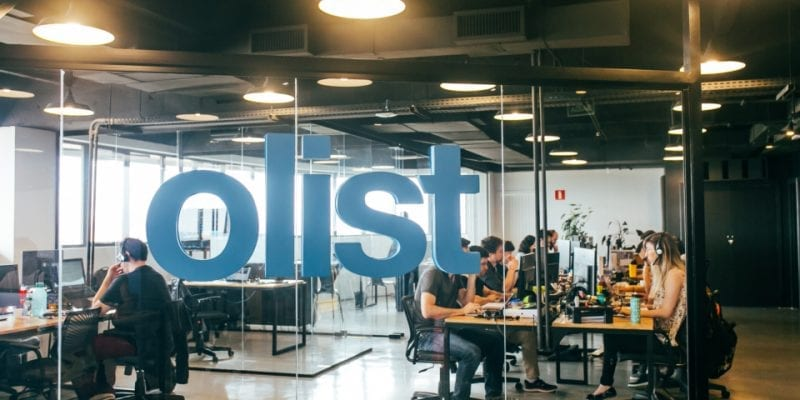

# Brazilian E-Commerce Olist Customers Segmentation

Vous êtes consultant pour Olist, une solution de vente sur les marketplaces en ligne.

Olist souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.

Vous devrez fournir à l’équipe marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

Les données
Pour cette mission, Olist vous fournit une base de données anonymisée comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.

Votre mission
Votre mission est d’aider les équipes d’Olist à comprendre les différents types d'utilisateurs. Vous utiliserez donc des méthodes non supervisées pour regrouper ensemble des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe marketing pour mieux communiquer.

In [54]:
#! usr/bin/env python 3
# coding: utf-8

# Importing librairies

import numpy as np                # numerical data processing
import pandas as pd               # numerical tables & time series
import scipy as sp                # numerical integration, interpolation, optimization, linear algebra, and statistics
import scipy.stats as st          # statistical functions
import seaborn as sns             # statistical data visualization
import matplotlib.pyplot as plt   # static, animated, and interactive visualizations in Python
import xgboost as xgb
import time
import warnings
warnings.filterwarnings('ignore')
%load_ext pycodestyle_magic
%pycodestyle_on

from sklearn.preprocessing import StandardScaler
from IPython.display import HTML

1:1: E265 block comment should start with '# '
8:80: E501 line too long (118 > 79 characters)
11:80: E501 line too long (94 > 79 characters)
19:1: E402 module level import not at top of file
20:1: E402 module level import not at top of file


The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


__FONCTION DEFINED TO HELP DESCRIBING THE CHARACTERISTICS OF THE INPUT FILES__

In [55]:
def duplicates(data):
    """Calculate the number of duplicates in dataframe data"""

    return len(data)-len(data.drop_duplicates())


def missing_cells(data):
    """Calculate the number of empty cells in dataframe data"""

    return data.isna().sum().sum()


def missing_cells_percent(data):
    """Calculate the percentage of empty cells in dataframe data"""

    return missing_cells(data)/(data.size)*100


def filled_cells(data):
    """Calculate the number of existing values in dataframe data"""

    return data.notna().sum()


def filled_cells_percent(data):
    """Calculate the percentage of existing values in dataframe data"""

    return filled_cells(data)/(len(data.index))*100

In [56]:
# Transforming our input files.csv from the cleaning phase to dataframe

customers = pd.read_csv("olist_customers_dataset.csv")
geolocation = pd.read_csv("olist_geolocation_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
order_payments = pd.read_csv("olist_order_payments_dataset.csv")
order_reviews = pd.read_csv("olist_order_reviews_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")
translation = pd.read_csv("product_category_name_translation.csv")

## CUSTOMERS

In [57]:
customers.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP


In [58]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


This dataset has information about the customer and its location. Use it to identify unique customers in the orders dataset and to find the orders delivery location.

At our system each order is assigned to a unique customerid. This means that the same customer will get different ids for different orders. The purpose of having a customerunique_id on the dataset is to allow you to identify customers that made repurchases at the store. Otherwise you would find that each order had a different customer associated with.

Please refer to the data schema:

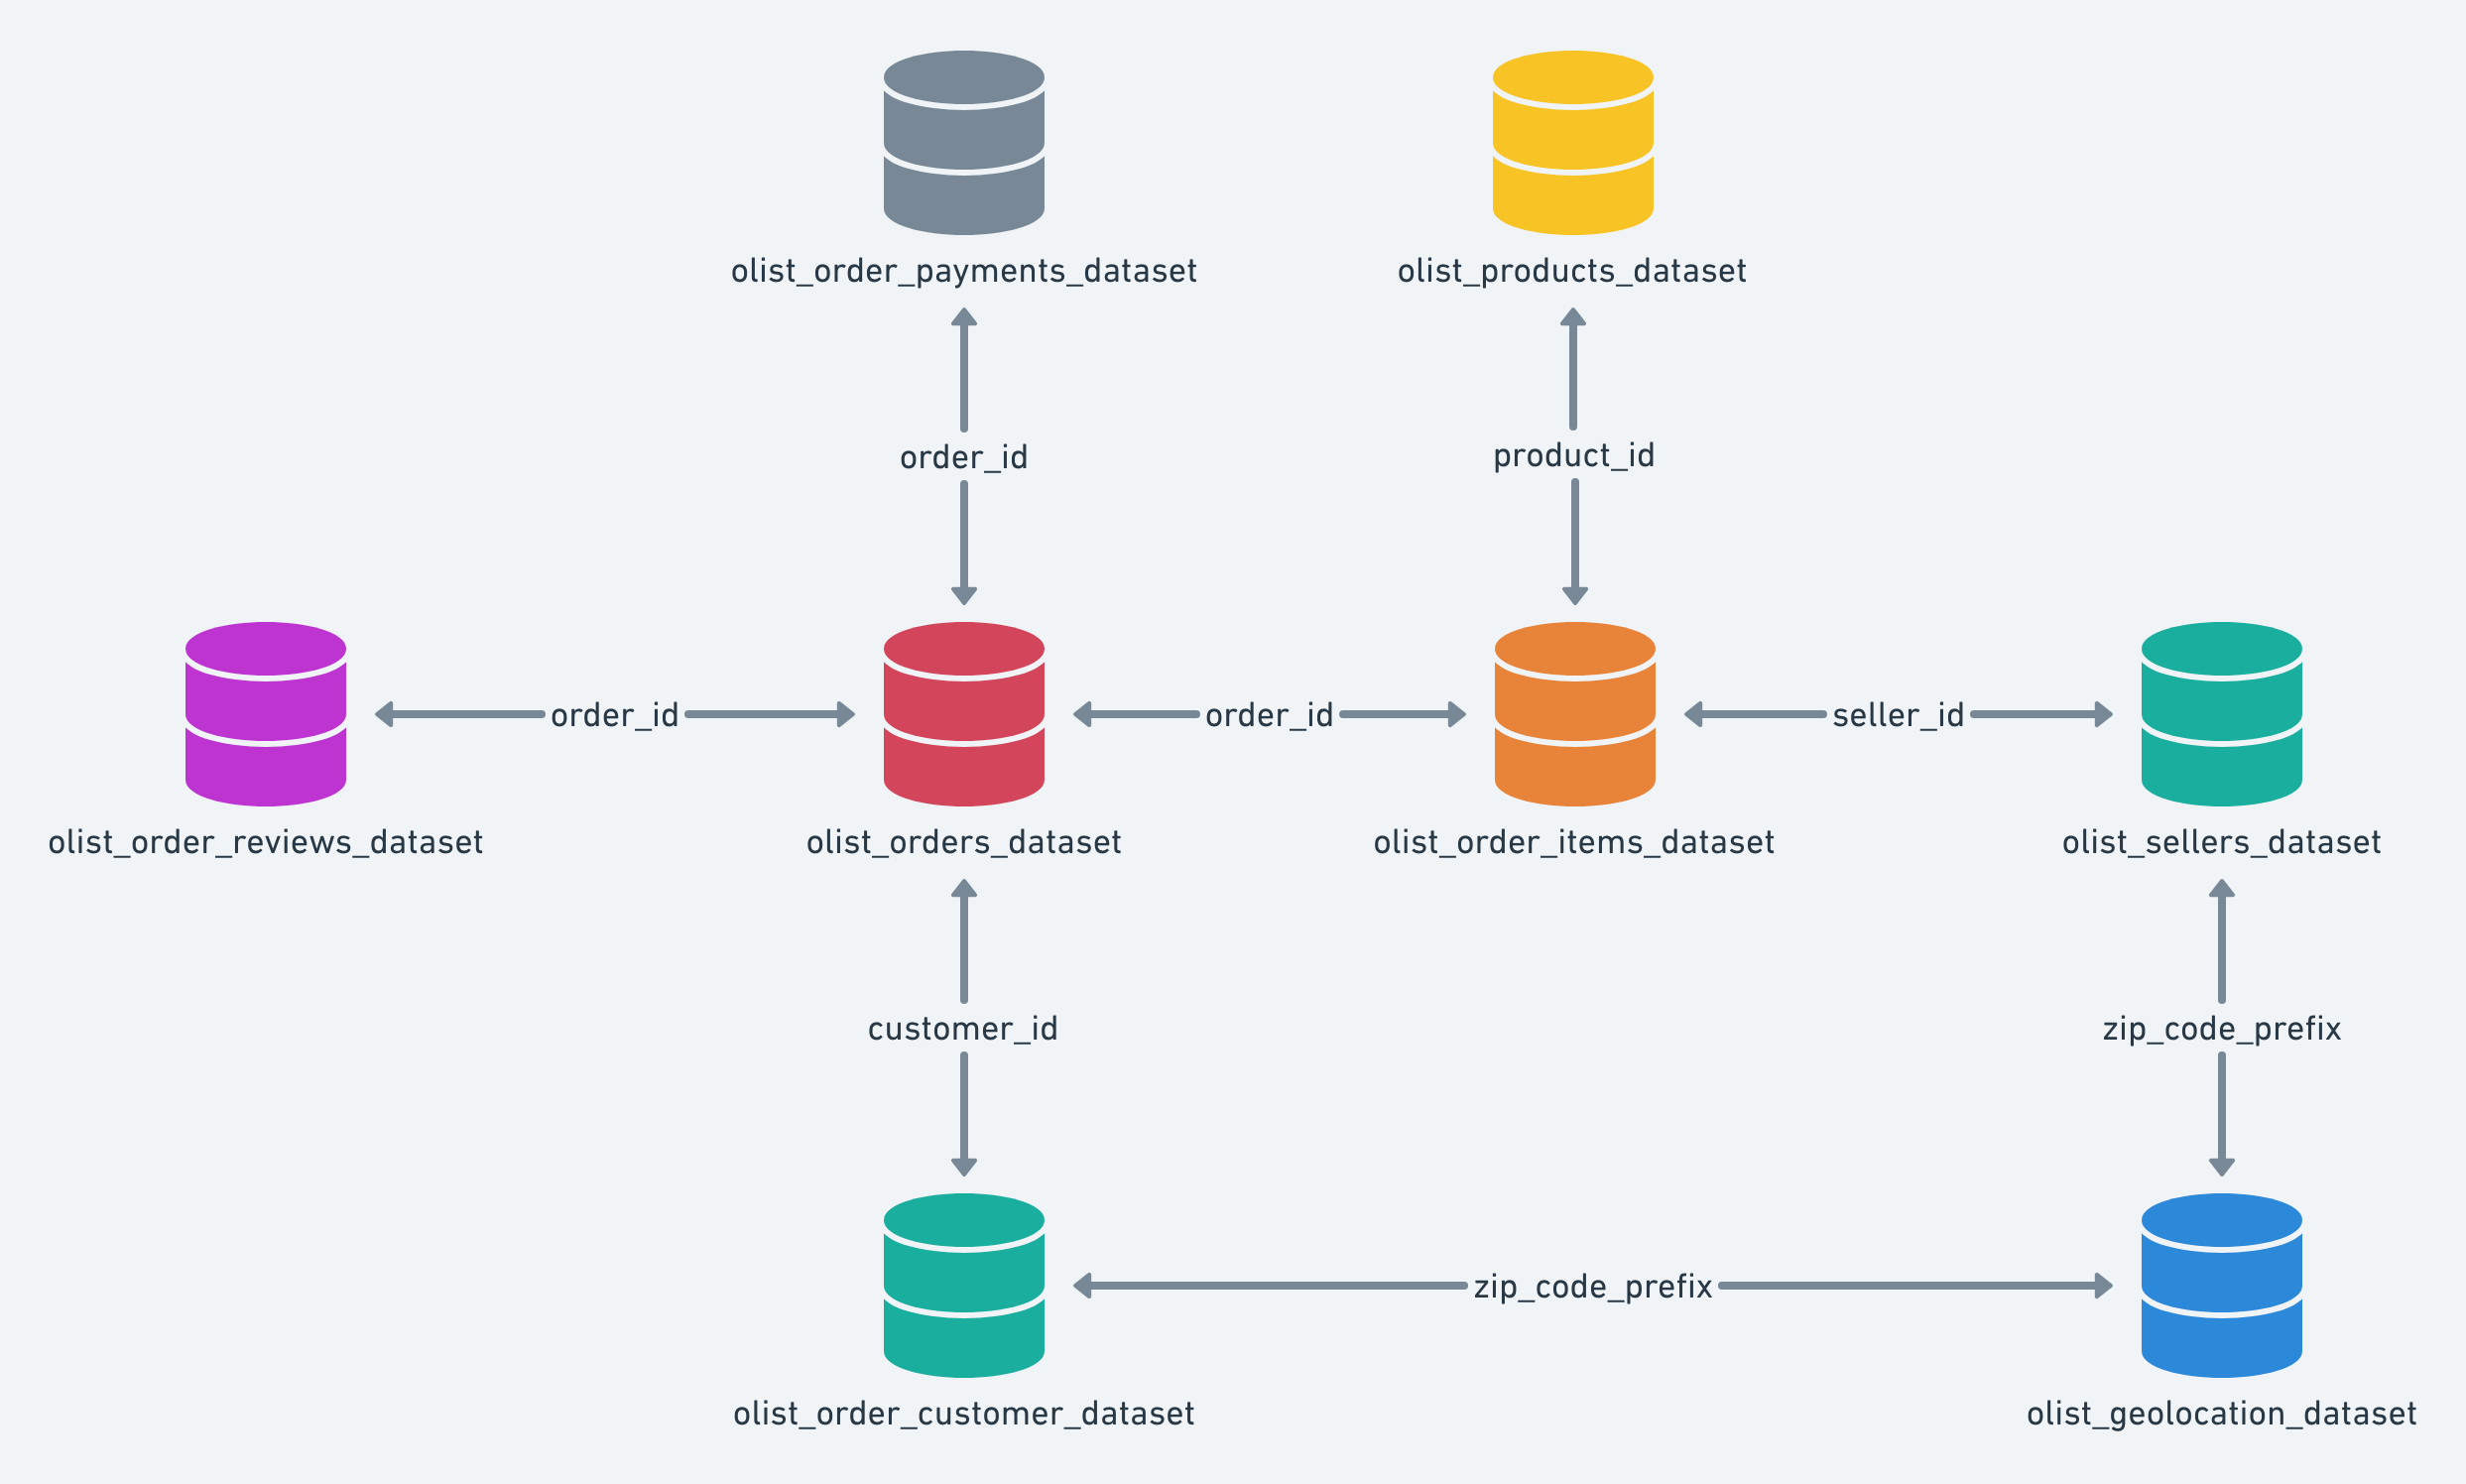

## GEOLOCATION

In [59]:
geolocation.head(2)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP


In [60]:
geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


This dataset has information Brazilian zip codes and its lat/lng coordinates. Use it to plot maps and find distances between sellers and customers.

## ORDER ITEMS

In [61]:
order_items.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93


In [62]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


This dataset includes data about the items purchased within each order.

## ORDER PAYMENTS

In [63]:
order_payments.head(2)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39


This dataset includes data about the orders payment options.

## ORDER REVIEWS

In [64]:
order_reviews.head(2)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13


In [65]:
order_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


This dataset includes data about the reviews made by the customers.

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.

## ORDERS

In [66]:
orders.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00


In [67]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


This is the core dataset. From each order you might find all other information.

## TRANSLATION

In [68]:
translation.head(2)

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories


Translates the product/category name to english.

## PRODUCTS

In [69]:
products.head(2)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0


In [70]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


This dataset includes data about the products sold by Olist.

## SELLERS

In [71]:
sellers.head(2)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP


In [72]:
sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


This dataset includes data about the sellers that fulfilled orders made at Olist. Use it to find the seller location and to identify which seller fulfilled each product.

In [73]:
# INITIALISE FILES_SPEC TO SERIES DICTIONARY
%pycodestyle_off
list_files = ["olist_customers_dataset.csv",
              "olist_geolocation_dataset.csv",
              "olist_order_items_dataset.csv",
              "olist_order_payments_dataset.csv",
              "olist_order_reviews_dataset.csv",
              "olist_orders_dataset.csv",
              "olist_products_dataset.csv",
              "olist_sellers_dataset.csv",
              "product_category_name_translation.csv"]

files_spec = {'Total rows': pd.Series([len(customers),
                                       len(geolocation),
                                       len(order_items),
                                       len(order_payments),
                                       len(order_reviews),
                                       len(orders),
                                       len(products),
                                       len(sellers),
                                       len(translation)],
                        index = list_files),
'Total columns': pd.Series([len(customers.columns),
                            len(geolocation.columns),
                            len(order_items.columns),
                            len(order_payments.columns),
                            len(order_reviews.columns),
                            len(orders.columns),
                            len(products.columns),
                            len(sellers.columns),
                            len(translation.columns)],
                        index = list_files),
'Total duplicates': pd.Series([duplicates(customers),
                               duplicates(geolocation),
                               duplicates(order_items),
                               duplicates(order_payments),
                               duplicates(order_reviews),
                               duplicates(orders),
                               duplicates(products),
                               duplicates(sellers),
                               duplicates(translation)],
                        index = list_files),
'Total Missing cells': pd.Series([missing_cells(customers),
                                  missing_cells(geolocation),
                                  missing_cells(order_items),
                                  missing_cells(order_payments),
                                  missing_cells(order_reviews),
                                  missing_cells(orders),
                                  missing_cells(products),
                                  missing_cells(sellers),
                                  missing_cells(translation)],
                        index = list_files),
'Missing cells (%)': pd.Series([missing_cells_percent(customers),
                                missing_cells_percent(geolocation),
                                missing_cells_percent(order_items),
                                missing_cells_percent(order_payments),
                                missing_cells_percent(order_reviews),
                                missing_cells_percent(orders),
                                missing_cells_percent(products),
                                missing_cells_percent(sellers),
                                missing_cells_percent(translation)],
                        index = list_files)}

# Creates Dataframe df_files_spec

df_files_spec = pd.DataFrame(files_spec)
index = df_files_spec.index
index.name = "Input File Name"
%pycodestyle_on
round(df_files_spec, 2)

,Total rows,Total columns,Total duplicates,Total Missing cells,Missing cells (%)
Input File Name,,,,,
olist_customers_dataset.csv,99441,5,0,0,0.00
olist_geolocation_dataset.csv,1000163,5,261831,0,0.00
olist_order_items_dataset.csv,112650,7,0,0,0.00
olist_order_payments_dataset.csv,103886,5,0,0,0.00
olist_order_reviews_dataset.csv,99224,7,0,145903,21.01
olist_orders_dataset.csv,99441,8,0,4908,0.62
olist_products_dataset.csv,32951,9,0,2448,0.83
olist_sellers_dataset.csv,3095,4,0,0,0.00
product_category_name_translation.csv,71,2,0,0,0.00


La segmentation RFM ou méthode RFM est une méthode de segmentation principalement développée à l'origine pour les actions de marketing direct des véadistes et qui s'applique désormais également aux acteurs du e-commerce et du commerce traditionnel.

La segmentation RFM prend en compte la Récence (date de la dernière commande), la Fréquence des commandes et le Montant (de la dernière commande ou sur une période donnée) pour établir des segments de clients homogènes.

La segmentation RFM permet de cibler les offres, d'établir des segments basés sur la valeur des clients et de prévenir l'attrition en identifiant des segments à risque.

Les données RFM restent des données très utilisées, mais une "simple" segmentation RFM est de plus en plus rare. Les données RFM sont désormais intégrées dans des procédures de ciblage et de segmentation comportant de plus en plus de variables et de données. Elles dépassent désormais le cadre du marketing direct et peuvent s'appliquer à la publicité display en utilisant une DMP et des procédures de CRM onboarding.


### 1. ORDER TO ORDER items on order_id

In [74]:
item_order = pd.merge(orders, order_items, how="left", on='order_id')
item_order

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113420,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,1.0,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,2018-02-12 13:10:37,174.90,20.10
113421,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,1.0,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,2017-09-05 15:04:16,205.99,65.02
113422,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,1.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59
113423,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,2.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59


### 2. PAYMENTS TO ORDERS on order_id

In [75]:
item_order_pay = pd.merge(item_order, order_payments,
                          on='order_id')
item_order_pay

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,1,credit_card,1,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,3,voucher,1,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,2,voucher,1,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,1,boleto,1,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,1,credit_card,3,179.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118426,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,1.0,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,2018-02-12 13:10:37,174.90,20.10,1,credit_card,3,195.00
118427,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,1.0,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,2017-09-05 15:04:16,205.99,65.02,1,credit_card,5,271.01
118428,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,1.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59,1,credit_card,4,441.16
118429,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,2.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59,1,credit_card,4,441.16


### 3. REVIEWS TO ORDERS/PAYMENTS on order_id

In [76]:
pay_review = pd.merge(order_reviews, item_order_pay, on='order_id')
pay_review

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_id,order_status,order_purchase_timestamp,...,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,...,1.0,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,2018-01-18 15:47:59,185.00,13.63,1,credit_card,8,397.26
1,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,...,2.0,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,2018-01-18 15:47:59,185.00,13.63,1,credit_card,8,397.26
2,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13,8a2e7ef9053dea531e4dc76bd6d853e6,delivered,2018-02-28 12:25:19,...,1.0,be0dbdc3d67d55727a65d4cd696ca73c,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-06 12:48:39,79.79,8.30,1,credit_card,1,88.09
3,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24,e226dfed6544df5b7b87a48208690feb,delivered,2018-02-03 09:56:22,...,1.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-02-08 10:31:15,149.00,45.12,1,credit_card,1,194.12
4,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,de6dff97e5f1ba84a3cd9a3bc97df5f6,delivered,2017-04-09 17:41:13,...,1.0,52c80cedd4e90108bf4fa6a206ef6b03,a1043bafd471dff536d0c462352beb48,2017-04-13 17:55:19,179.99,42.85,1,credit_card,1,222.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118138,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-07 00:00:00,2018-07-14 17:18:30,d8c466a3e7c4cda36cd4ae7d577f44f4,delivered,2018-06-27 17:31:29,...,1.0,4fb209073dc2ab6a6d3c259a7c285501,5343d0649eca2a983820bfe93fc4d17e,2018-07-02 17:30:37,226.77,61.20,1,credit_card,8,287.97
118139,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42,d0d7086dea6fcf42b9b690b9f3745c58,delivered,2017-12-03 21:45:23,...,1.0,3a33c980b62eb1ef3b8ae61b6fc6fe55,46dc3b2cc0980fb8ec44634e21d2718e,2017-12-07 22:08:00,199.99,9.77,1,credit_card,1,209.76
118140,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43,fcc7b1caafe3b77fd587bab964c4d1fb,delivered,2018-03-18 09:52:19,...,1.0,8ba0118a487ec8671aed57e5ef846574,17ca9b9e9b9ef8fdb529001b49ebb50f,2018-03-22 10:08:04,215.97,15.59,1,credit_card,6,231.56
118141,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13,3aa00401736823c73e9fe8683328fa6b,delivered,2018-06-22 16:47:28,...,1.0,73a7fbf8c1048131f3b531af31bcdf0e,8d956fec2e4337affcb520f56fd8cbfd,2018-06-26 18:15:29,50.95,15.46,1,credit_card,1,66.41


### 4. CUSTOMERS on order_id

In [77]:
pay_review_cust = pd.merge(customers, pay_review,
                           on='customer_id')
pay_review_cust

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_id,order_id,review_score,review_comment_title,review_comment_message,...,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,88b8b52d46df026a9d1ad2136a59b30b,00e7ee1b050b8499577073aeb2a297a1,4,NaN,NaN,...,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,1,credit_card,2,146.87
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,02fc48a9efa3e3d0f1a8ea26507eeec3,29150127e6685892b6eab3eec79f59c7,5,NaN,NaN,...,1.0,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,1,credit_card,8,335.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,5ad6695d76ee186dc473c42706984d87,b2059ed67ce144a36e2aa97d2c9e9ad2,5,NaN,NaN,...,1.0,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,1,credit_card,7,157.73
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,059a801bb31f6aab2266e672cab87bc5,951670f92359f4fe4a63112aa7306eba,5,NaN,NaN,...,1.0,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,1,credit_card,1,173.30
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,8490879d58d6c5d7773f2739a03f089a,6b7d50bd145f6fc7f33cebabd7e49d0f,5,a melhor nota,O baratheon è esxelente Amo adoro o baratheon,...,1.0,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25,1,credit_card,8,252.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118138,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,36e2cdbaa9f639b57c53b37ac798fee8,6760e20addcf0121e9d58f2f1ff14298,4,Recomendo,NaN,...,1.0,ccb4503d9d43d245d3b295d0544f988b,527801b552d0077ffd170872eb49683b,2018-04-12 16:08:45,74.90,13.88,1,credit_card,6,88.78
118139,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,b273b431c3aedb4eed18643309652940,9ec0c8947d973db4f4e8dcf1fbfa8f1b,5,NaN,NaN,...,1.0,9ede6b0570a75a4b9de4f383329f99ee,3fd1e727ba94cfe122d165e176ce7967,2018-04-10 08:35:12,114.90,14.16,1,credit_card,3,129.06
118140,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fa4f16891e6b2edd1354668d07f5648b,fed4434add09a6f332ea398efd656a5c,1,Chateada,Esperava qualidade no atendimento e estou tend...,...,1.0,7a5d2e1e131a860ae7d18f6fffa9d689,d9e7e7778b32987280a6f2cb9a39c57d,2018-04-12 20:30:03,37.00,19.04,1,credit_card,5,56.04
118141,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,0bcdc9e450ea500811a8d39ee993cd47,e31ec91cea1ecf97797787471f98a8c2,5,NaN,NaN,...,1.0,f819f0c84a64f02d3a5606ca95edd272,4869f7a5dfa277a7dca6462dcf3b52b2,2017-11-09 21:15:51,689.00,22.07,1,credit_card,2,711.07


### 5. SELLERS on seller_id

In [78]:
sell_cust = pd.merge(pay_review_cust, sellers,
                     on='seller_id')
sell_cust

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_id,order_id,review_score,review_comment_title,review_comment_message,...,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,seller_zip_code_prefix,seller_city,seller_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,88b8b52d46df026a9d1ad2136a59b30b,00e7ee1b050b8499577073aeb2a297a1,4,NaN,NaN,...,2017-05-22 15:22:12,124.99,21.88,1,credit_card,2,146.87,8577,itaquaquecetuba,SP
1,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,5ad6695d76ee186dc473c42706984d87,b2059ed67ce144a36e2aa97d2c9e9ad2,5,NaN,NaN,...,2018-06-05 16:19:10,139.94,17.79,1,credit_card,7,157.73,8577,itaquaquecetuba,SP
2,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,059a801bb31f6aab2266e672cab87bc5,951670f92359f4fe4a63112aa7306eba,5,NaN,NaN,...,2018-03-27 16:31:16,149.94,23.36,1,credit_card,1,173.30,8577,itaquaquecetuba,SP
3,4c06b42fbf7b97ab10779cda5549cd1c,07d190f123147d9e89d4b922543d7948,65075,sao luis,MA,2518803238cabbf63564593e4a8fc52d,997fd4b37386d10b57d4ac8cdec011a6,1,Nada de produto,"Ainda não recebi o produto. Sendo assim, não p...",...,2018-07-26 10:30:15,199.98,115.77,1,credit_card,6,315.75,8577,itaquaquecetuba,SP
4,8276de07ef25225d412b8462d73f8664,332cf4e83e16004ba7dca932ce82475b,90010,porto alegre,RS,84467f1766775ba4c14fc25b3ca67905,b63fff1ef8b6201df68bb611ee41129e,4,NaN,"A crítica é à entrega, pois por se tratar dos ...",...,2017-04-17 05:55:19,129.60,16.61,1,boleto,1,146.21,8577,itaquaquecetuba,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117324,eda10d7eb51a675d000956fa1aabc7dd,5c22dbb9d8b5385953f2f1e6d9d115a7,39920,jordania,MG,709ee020ff826ee5289d7dd5d6911d0c,b494f624c631105b24fe497277085909,5,NaN,NaN,...,2018-08-08 18:50:15,49.90,22.28,1,credit_card,3,72.18,87015,maringa,PR
117325,f0f671d4034e98cdf20f0c452d6db02b,6532316a8c1a7c7a569482db073530bb,7231,guarulhos,SP,274e38de8990f74fc03894fa488b5cd5,f73b31435ce6dec43df056154c39a1ce,3,PRODUTO,NÃO TENHO COMO AVALIAR POIS AINDA NÃO RECEBI O...,...,2018-08-24 15:34:56,730.00,45.98,1,credit_card,10,775.98,9861,sbc,SP
117326,b90b857a277b080d8078332b3636ab58,7f5f43a9394964ac51bc5d1e0204ead4,76400,uruacu,GO,6010e1ba95a9e19dc10a7b761932cf98,d76fe905f4588ad69ab3b36527bb267d,5,NaN,NaN,...,2018-08-21 21:10:13,135.98,88.46,1,credit_card,6,224.44,83015,sao jose dos pinhais,PR
117327,1ed0c832c2dd99570a59260e71768bdf,82d46759af0369aad49084bacf85a6c3,37610,bom repouso,MG,603f2873842a6975a43c54d305397d69,51c6d2f460589fa7b65f2da51e860206,1,NaN,NaN,...,2017-11-24 12:15:25,167.99,31.93,1,credit_card,5,167.79,12914,braganca paulista,SP


### 6. PRODUCTS on product_id

In [79]:
sell_cust_products = pd.merge(sell_cust, products,
                              on='product_id')
sell_cust_products

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_id,order_id,review_score,review_comment_title,review_comment_message,...,seller_city,seller_state,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,88b8b52d46df026a9d1ad2136a59b30b,00e7ee1b050b8499577073aeb2a297a1,4,NaN,NaN,...,itaquaquecetuba,SP,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,7fc63200f12eebb5f387856afdd63db8,c1d2b34febe9cd269e378117d6681172,1,NaN,"GOSTARIA DE UMA SOLUÇÃO, ESTOU PRECISANDO MUIT...",...,itaquaquecetuba,SP,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,7fc63200f12eebb5f387856afdd63db8,c1d2b34febe9cd269e378117d6681172,1,NaN,"GOSTARIA DE UMA SOLUÇÃO, ESTOU PRECISANDO MUIT...",...,itaquaquecetuba,SP,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS,251191809e37c1cffc16865947c18a4d,b1a5d5365d330d10485e0203d54ab9e8,3,NaN,"Produto compatível com seu valor, muito bonito...",...,itaquaquecetuba,SP,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ,f7123bac5b91a0e2e38d8b41fd1206f4,2e604b3614664aa66867856dba7e61b7,4,NaN,Entregou antes do prazo,...,itaquaquecetuba,SP,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117324,eda10d7eb51a675d000956fa1aabc7dd,5c22dbb9d8b5385953f2f1e6d9d115a7,39920,jordania,MG,709ee020ff826ee5289d7dd5d6911d0c,b494f624c631105b24fe497277085909,5,NaN,NaN,...,maringa,PR,pet_shop,51.0,433.0,1.0,200.0,40.0,7.0,32.0
117325,f0f671d4034e98cdf20f0c452d6db02b,6532316a8c1a7c7a569482db073530bb,7231,guarulhos,SP,274e38de8990f74fc03894fa488b5cd5,f73b31435ce6dec43df056154c39a1ce,3,PRODUTO,NÃO TENHO COMO AVALIAR POIS AINDA NÃO RECEBI O...,...,sbc,SP,casa_construcao,42.0,2129.0,1.0,15008.0,47.0,31.0,51.0
117326,b90b857a277b080d8078332b3636ab58,7f5f43a9394964ac51bc5d1e0204ead4,76400,uruacu,GO,6010e1ba95a9e19dc10a7b761932cf98,d76fe905f4588ad69ab3b36527bb267d,5,NaN,NaN,...,sao jose dos pinhais,PR,ferramentas_jardim,55.0,835.0,8.0,3211.0,36.0,53.0,22.0
117327,1ed0c832c2dd99570a59260e71768bdf,82d46759af0369aad49084bacf85a6c3,37610,bom repouso,MG,603f2873842a6975a43c54d305397d69,51c6d2f460589fa7b65f2da51e860206,1,NaN,NaN,...,braganca paulista,SP,eletronicos,33.0,63.0,1.0,6185.0,63.0,11.0,20.0


### 7. TRANSLATION on product_id

In [80]:
ord_items_products_eng = pd.merge(sell_cust_products, translation,
                                  on='product_category_name')
ord_items_products_eng

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_id,order_id,review_score,review_comment_title,review_comment_message,...,seller_state,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,88b8b52d46df026a9d1ad2136a59b30b,00e7ee1b050b8499577073aeb2a297a1,4,NaN,NaN,...,SP,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,7fc63200f12eebb5f387856afdd63db8,c1d2b34febe9cd269e378117d6681172,1,NaN,"GOSTARIA DE UMA SOLUÇÃO, ESTOU PRECISANDO MUIT...",...,SP,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,7fc63200f12eebb5f387856afdd63db8,c1d2b34febe9cd269e378117d6681172,1,NaN,"GOSTARIA DE UMA SOLUÇÃO, ESTOU PRECISANDO MUIT...",...,SP,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS,251191809e37c1cffc16865947c18a4d,b1a5d5365d330d10485e0203d54ab9e8,3,NaN,"Produto compatível com seu valor, muito bonito...",...,SP,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ,f7123bac5b91a0e2e38d8b41fd1206f4,2e604b3614664aa66867856dba7e61b7,4,NaN,Entregou antes do prazo,...,SP,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115604,0fbd856ba1d4961786fb54bd448eb7fe,96328ac15f58fbb232fe14b182103382,89675,vargem bonita,SC,45c02db2f81c1968c58f08d46694213d,937592924b66482b823ee7ecd185d0ff,4,NaN,NaN,...,SC,la_cuisine,59.0,284.0,2.0,12500.0,83.0,21.0,43.0,la_cuisine
115605,98a1b4f80dd0ccb7d1ae5a75ba5c904e,bf5ed75fca98e8f79c49e9a5bf7690e1,13480,limeira,SP,79edb538f521d901d1167e50b4c4101f,28915ae2a90c218f0c2b7f8e0fb280e0,1,NaN,faltou a forma e nao consigo entrar em contato...,...,SC,la_cuisine,41.0,194.0,1.0,450.0,31.0,10.0,18.0,la_cuisine
115606,aa0533eb31ed3be79086f11bb2bec430,a490d5875edefe9bb8f5101ec2f6b56f,13870,sao joao da boa vista,SP,f8c39654aa2349dfb94f274ccefe7c80,e22a3e8048469ea68906f666d446c25c,5,NaN,NaN,...,SC,la_cuisine,59.0,731.0,1.0,2200.0,84.0,12.0,15.0,la_cuisine
115607,d11524bb77c28efad04e4467eac8a660,6968d41eb700f1ea39424e04b854bf7e,30130,belo horizonte,MG,4dc7a70acb9d9eeeb1db4e74f88b2e9b,1ce0acf125f1bcd636276dd213363196,5,NaN,Recomendo,...,SC,la_cuisine,57.0,429.0,1.0,2700.0,85.0,7.0,40.0,la_cuisine


In [81]:
# We drop the product category name in portuguese to work with the english one
df_gross = ord_items_products_eng.drop('product_category_name', axis=1)

In [82]:
df_gross.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115609 entries, 0 to 115608
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    115609 non-null  object 
 1   customer_unique_id             115609 non-null  object 
 2   customer_zip_code_prefix       115609 non-null  int64  
 3   customer_city                  115609 non-null  object 
 4   customer_state                 115609 non-null  object 
 5   review_id                      115609 non-null  object 
 6   order_id                       115609 non-null  object 
 7   review_score                   115609 non-null  int64  
 8   review_comment_title           13801 non-null   object 
 9   review_comment_message         48906 non-null   object 
 10  review_creation_date           115609 non-null  object 
 11  review_answer_timestamp        115609 non-null  object 
 12  order_status                  

In [83]:
df_gross.to_csv('data_gross.csv')

### ##########################################

### CLEANING & EXPLORATION 

In [84]:
df_gross['product_category_name_english'].value_counts()

bed_bath_table               11847
health_beauty                 9944
sports_leisure                8942
furniture_decor               8743
computers_accessories         8105
                             ...  
arts_and_craftmanship           24
la_cuisine                      15
cds_dvds_musicals               14
fashion_childrens_clothes        8
security_and_services            2
Name: product_category_name_english, Length: 71, dtype: int64

Dictionary construction to regroup products category from 71 to 11 categories.

In [ ]:
product_cat_dict = {
    'construction_tools_construction': 'construction',
    'construction_tools_lights': 'construction',
    'construction_tools_safety': 'construction',
    'costruction_tools_garden': 'construction',
    'costruction_tools_tools': 'construction',
    'garden_tools': 'construction',
    'home_construction': 'construction',

    'fashio_female_clothing': 'fashion',
    'fashion_bags_accessories': 'fashion',
    'fashion_childrens_clothes': 'fashion',
    'fashion_male_clothing': 'fashion',
    'fashion_shoes': 'fashion',
    'fashion_sport': 'fashion',
    'fashion_underwear_beach': 'fashion',

    'furniture_bedroom': 'furniture',
    'furniture_decor': 'furniture',
    'furniture_living_room': 'furniture',
    'furniture_mattress_and_upholstery': 'furniture',
    'bed_bath_table': 'furniture',
    'kitchen_dining_laundry_garden_furniture': 'furniture',
    'office_furniture': 'furniture',

    'home_appliances': 'home',
    'home_appliances_2': 'home',
    'home_comfort_2': 'home',
    'home_confort': 'home',
    'air_conditioning': 'home',
    'housewares': 'home',
    'art': 'home',
    'arts_and_craftmanship': 'home',
    'flowers': 'home',
    'cool_stuff': 'home',

    'drinks': 'food_drink',
    'food': 'food_drink',
    'food_drink': 'food_drink',
    'la_cuisine': 'food_drink',

    'electronics': 'electronics',
    'audio': 'electronics',
    'tablets_printing_image': 'electronics',
    'telephony': 'electronics',
    'fixed_telephony': 'electronics',
    'small_appliances': 'electronics',
    'small_appliances_home_oven_and_coffee': 'electronics',
    'computers_accessories': 'electronics',
    'computers': 'electronics',

    'sports_leisure': 'sports_leisure',
    'consoles_games': 'sports_leisure',
    'musical_instruments': 'sports_leisure',
    'toys': 'sports_leisure',
    'cine_photo': 'sports_leisure',
    'dvds_blu_ray': 'sports_leisure',
    'cds_dvds_musicals': 'sports_leisure',
    'music': 'sports_leisure',
    'books_general_interest': 'sports_leisure',
    'books_imported': 'sports_leisure',
    'books_technical': 'sports_leisure',

    'health_beauty': 'health_beauty',
    'perfumery': 'health_beauty',
    'diapers_and_hygiene': 'health_beauty',
    'baby': 'health_beauty',

    'christmas_supplies': 'supplies',
    'stationery': 'supplies',
    'party_supplies': 'supplies',
    'auto': 'supplies',
    'luggage_accessories': 'supplies',

    'watches_gifts': 'gifts',

    'agro_industry_and_commerce': 'misc',
    'industry_commerce_and_business': 'misc',
    'security_and_services': 'misc',
    'signaling_and_security': 'misc',
    'market_place': 'misc',
    'pet_shop': 'misc',
}

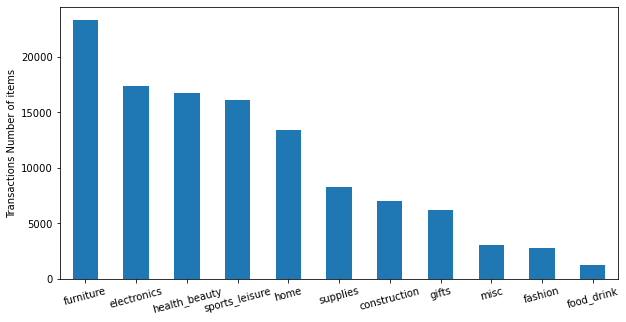

2:23: E127 continuation line over-indented for visual indent


In [89]:
df_gross.replace({"product_category_name_english":
                      product_cat_dict}, inplace=True)
plt.rcParams["figure.figsize"] = (10, 5)
df_gross['product_category_name_english'].value_counts() \
                                             .plot(kind='bar', rot=15)
plt.ylabel('Transactions Number of items')
plt.show()

In [ ]:
print('Number of products with no name:', len(products)-len(products_eng))

In [ ]:
Features_with_NA = [feature for feature in sell_cust.columns if sell_cust[feature].isnull().sum() >=1]
for feature in Features_with_NA:
  print(feature, np.round(sell_cust[feature].isnull().mean()*100,4),'%', 'and total nulls are',np.round(sell_cust[feature].isnull().sum(),4))

In [ ]:
sell_cust['total_price'] = sell_cust['price'] + sell_cust['freight_value']

In [ ]:
sell_cust

In [ ]:
sell_cust['diff'] = sell_cust['payment_value'] - sell_cust['total_price']
sell_cust['diff'].astype(bool).sum(axis=0)